# **European Option Pricing: Black-Scholes vs Binomial Tree**
Author: *Aditya Rana*

Enrollment Number: 23113014

This notebook implements and compares two foundational models for pricing European options:
- The **Binomial Tree model** (discrete time)
- The **Black-Scholes model** (continuous time)

The analysis includes:
 -  Implementation of both models in Python

 - Retrieval and use of real market data (e.g., AAPL – Apple Inc.) for validation

 - Convergence behavior of the Binomial Tree model toward the Black-Scholes price

 - Computational efficiency trends of the Binomial Tree model

 - Sensitivity analysis with respect to key parameters (volatility, time to maturity, risk-free rate, strike price)
 - Pricing accuracy and deviation from observed market prices

 - Visualization of the Binomial Tree structure (up to 5 steps)

 - Error convergence of the Binomial Tree model

 - A performance analysis report

 - Conclusions and references

## **Some commonly used terms and representations**
1. The current stock price - S0
2. The strike price - K
3. The time to expiration - T
4. The volatility of the stock price - sigma
5. The risk-free interest rate - r
6. The stock price at maturity - ST
7. Greeks -  set of risk sensitivity measures that describe how an option’s price changes in response to various factors.
 - Delta (Δ) - Measures how much the option price changes for a $1 change in the underlying asset.

 - Gamma (Γ) -
Measures how much Delta changes for a $1 change in the underlying asset.
 - Vega (ν) -
Measures how much the option price changes for a 1% change in implied volatility.
 - Theta (θ) -
Measures how much the option price decays with one day closer to expiration (time decay).
 - Rho (ρ) -
Measures how much the option price changes for a 1% change in the risk-free interest rate.
8. AAPL - stock ticker symbol for Apple Inc.

## **Importing the required libraries**

In [72]:
import numpy as np
import scipy.stats as si
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import time

sns.set_theme(style="darkgrid")
%matplotlib inline

## **Implementation Of Binomial Tree Model with Variabler Step Control**

In [73]:
"""
- N: Number of steps in the tree (if not given, taking the default value of 40 (typically used value))
- option_type: 'call' or 'put' (if not given, taking the default value of call)
- Returns:
    - Option price
    - Stock price tree (2D array)
    - Option value tree (2D array)
"""
def Binomial_Tree(S, K, T, r, sigma, N = 40, option_type = 'call'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    stock_tree = np.zeros((N + 1, N + 1))
    option_tree = np.zeros((N + 1, N + 1))

    for i in range(N + 1):
        stock_tree[i, N] = S * (u ** (N - i)) * (d ** i)

    if option_type == 'call':
        option_tree[:, N] = np.maximum(stock_tree[:, N] - K, 0)
    else:
        option_tree[:, N] = np.maximum(K - stock_tree[:, N], 0)

    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            option_tree[i, j] = np.exp(-r * dt) * (
                p * option_tree[i, j + 1] + (1 - p) * option_tree[i + 1, j + 1]
            )
            stock_tree[i, j] = S * (u ** (j - i)) * (d ** i)

    return option_tree[0, 0], stock_tree, option_tree


## **Implementation Of Black-Scholes closed form formula with Option Greeks**

In [74]:
"""
- option_type: 'call' or 'put' (if not given, taking the default value of call)
Returns: Dictionary with price and Greeks: Delta, Gamma, Vega, Theta, Rho
"""
def Black_Scholes_with_Greeks(S, K, T, r, sigma, option_type = 'call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
        delta = si.norm.cdf(d1)
        theta = (-S * si.norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 - r * K * np.exp(-r * T) * si.norm.cdf(d2))
        rho = K * T * np.exp(-r * T) * si.norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)
        delta = si.norm.cdf(d1) - 1
        theta = (-S * si.norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 + r * K * np.exp(-r * T) * si.norm.cdf(-d2))
        rho = -K * T * np.exp(-r * T) * si.norm.cdf(-d2)

    gamma = si.norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * si.norm.pdf(d1) * np.sqrt(T)

    return {
        'price': price,
        'delta': delta,
        'gamma': gamma,
        'vega': vega / 100,
        'theta': theta / 365,
        'rho': rho / 100
    }


## **Collecting real market data of Apple Inc.**

In [75]:
def get_stock(ticker='AAPL'):
    return yf.Ticker(ticker)

def get_current_price(ticker='AAPL'):
    stock = get_stock(ticker)
    return stock.history(period='1d')['Close'].iloc[-1]

def get_historical_volatility(ticker='AAPL', period='1y'):
    stock = get_stock(ticker)
    hist = stock.history(period=period)
    returns = np.log(hist['Close'] / hist['Close'].shift(1))
    return returns.std() * np.sqrt(252)  # Annualized volatility

def get_risk_free_rate():
    return 0.05 # assumes a fixed risk free rate of 5% (usually accepted value)

def get_option_chain(ticker='AAPL'):
    stock = get_stock(ticker)
    expirations = stock.options
    if len(expirations) > 0:
        opt_chain = stock.option_chain(expirations[0])
        return opt_chain, expirations[0]
    return None, None

def get_valid_future_expiry(ticker='AAPL'):
    stock = get_stock(ticker)
    for exp in stock.options:
        expiry_date = pd.to_datetime(exp)
        delta_days = (expiry_date - pd.Timestamp.today()).days
        if delta_days > 0:
            T = delta_days / 365  # Time to maturity in years
            return exp, T
    return None, None

## **Binomial Tree Convergence and Computational Effeciency**

In [76]:
"""
Analyze the convergence of binomial option pricing to a stable value.
- Returns:
    - steps_list: list of number of steps
    - prices: option price at each step
    - times: computation time at each step
"""
def binomial_convergence_analysis(S, K, T, r, sigma, option_type = 'call', max_steps = 100, step_size = 5):
    steps_list = list(range(10, max_steps + 1, step_size))
    prices = []
    times = []

    for n in steps_list:
        start = time.time()
        price, _, _ = Binomial_Tree(S, K, T, r, sigma, n, option_type)
        end = time.time()

        prices.append(price)
        times.append(end - start)

    return steps_list, prices, times


In [77]:
def plot_convergence(steps_list, bt_prices, bs_price):
    plt.figure(figsize=(10, 6))

    plt.plot(steps_list, bt_prices, 'o-', color='#FFB823', linewidth=2, label='Binomial Tree')

    plt.axhline(y=bs_price, color='#0D92F4', linestyle='--', linewidth=2,
                label=f'Black-Scholes (${bs_price:.2f})')

    plt.xlabel('Number of Steps', fontsize=12)
    plt.ylabel('Option Price ($)', fontsize=12)
    plt.title('Convergence of Binomial Tree to Black-Scholes Price', fontsize=14)

    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [78]:
def plot_effeciency(steps_list, times):
    plt.figure(figsize=(10, 5))
    plt.plot(steps_list, times, marker='o', color='#CB0404')
    plt.title('Computation Time vs Number of Steps in Binomial Tree')
    plt.xlabel('Number of Steps')
    plt.ylabel('Time (seconds)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Binomial Tree Prices:
  10 steps: $2.9411 (error: 2.41%)
  20 steps: $2.9771 (error: 1.21%)
  50 steps: $2.9990 (error: 0.49%)
  100 steps: $3.0063 (error: 0.24%)
  200 steps: $3.0100 (error: 0.12%)


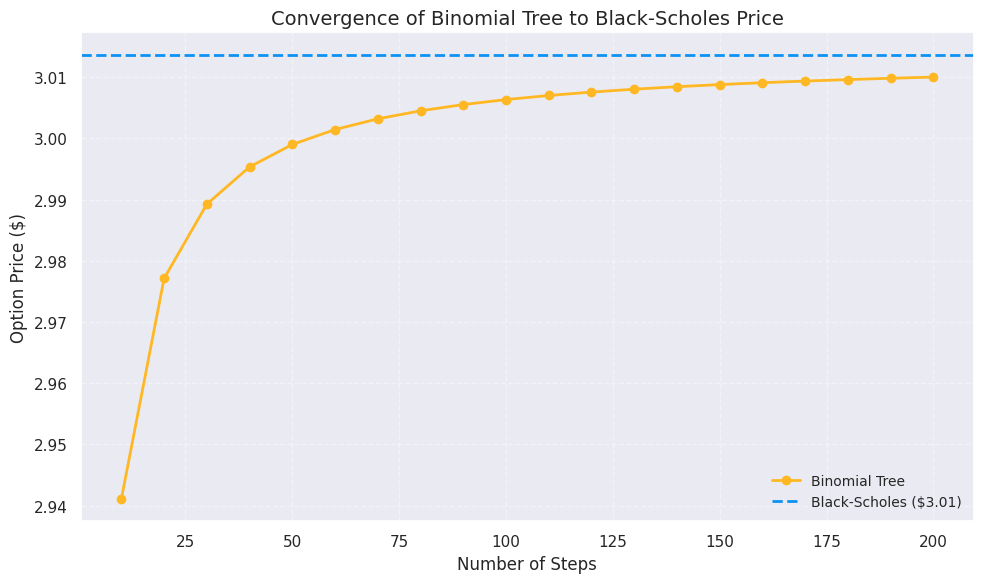

In [79]:
"""
using apple's market data to see the convergence of binaomial tree to black scholes model and
the dependence of computational effeiency of binomial tree with the increasing number of steps
"""
ticker = 'AAPL'
stock = get_stock(ticker)
S0 = get_current_price(ticker)
sigma = get_historical_volatility(ticker)
r = get_risk_free_rate()
expiry, T = get_valid_future_expiry(ticker)

bt_pricer = Binomial_Tree(S=S0, K=S0, T=T, r=r, sigma=sigma)
bs_price = Black_Scholes_with_Greeks(S=S0, K=S0, T=T, r=r, sigma=sigma)['price']
print("\nBinomial Tree Prices:")
for n_steps in [10, 20, 50, 100, 200]:
    bt_price, _, _ = Binomial_Tree(S=S0, K=S0, T=T, r=r, sigma=sigma, N = n_steps)
    error = abs(bt_price - bs_price) / bs_price * 100
    print(f"  {n_steps} steps: ${bt_price:.4f} (error: {error:.2f}%)")
bs_price = Black_Scholes_with_Greeks(S=S0, K=S0, T=T, r=r, sigma=sigma)['price']
for n in [10, 50, 100, 200]:
    bt_price, _, _ = Binomial_Tree(S=S0, K=S0, T=T, r=r, sigma=sigma, N = n)
    error = abs(bt_price - bs_price) / bs_price * 100
steps_list, prices, times = binomial_convergence_analysis(S=S0, K=S0, T=T, r=r, sigma=sigma, max_steps=200, step_size=10)
plot_convergence(steps_list, prices, bs_price)

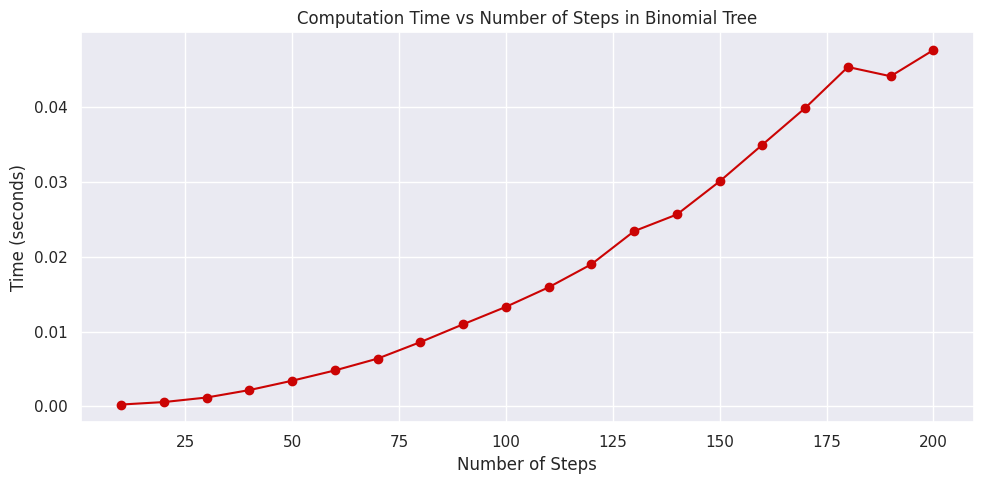

In [80]:
ticker = 'AAPL'
stock = get_stock(ticker)
S0 = get_current_price(ticker)
sigma = get_historical_volatility(ticker)
r = get_risk_free_rate()
expiry, T = get_valid_future_expiry(ticker)

steps_list, prices, times = binomial_convergence_analysis(S=S0, K=S0, T=T, r=r, sigma=sigma, max_steps=200, step_size=10)
plot_effeciency(steps_list, times)

## **Sensitivity of model prices to various factors**

In [81]:
"""
Analyze sensitivity to a specific parameter.

Parameters:
    base_params (dict): Base parameters with keys S0, K, T, r, sigma.
    param_name (str): Name of the parameter to vary.
    param_range (iterable): Range of values for the parameter.
    n_steps (int): Number of steps for Binomial Tree pricing.

Returns:
    bs_prices (list): Black-Scholes prices across param_range.
    bt_prices (list): Binomial Tree prices across param_range.
"""
def analyze_parameter(base_params, param_name, param_range, n_steps=50):
    bs_prices = []
    bt_prices = []

    for param_value in param_range:
        params = base_params.copy()
        params[param_name] = param_value

        # Black-Scholes price
        bs_price = Black_Scholes_with_Greeks(S=params['S0'], K=params['K'], T=params['T'], r=params['r'], sigma=params['sigma'])['price']
        bs_prices.append(bs_price)

        # Binomial Tree price
        bt_price, _, _ = Binomial_Tree(S=params['S0'], K=params['K'], T=params['T'], r=params['r'], sigma=params['sigma'], N=n_steps)
        bt_prices.append(bt_price)

    return bs_prices, bt_prices


"""
Parameters:
    base_params (dict): Base option parameters (S0, K, T, r, sigma).
    n_steps (int): Steps in Binomial Tree.

Returns:
    dict: Sensitivity results for each parameter.
"""
def create_sensitivity_report(base_params, n_steps=40):
    param_ranges = {
        'sigma': np.linspace(0.1, 0.5, 20),
        'T':     np.linspace(0.1, 2.0, 20),
        'r':     np.linspace(0.01, 0.10, 20),
        'K':     np.linspace(0.8 * base_params['S0'], 1.2 * base_params['S0'], 20)  # Strike
    }

    param_labels = {
        'sigma': 'volatility',
        'T': 'time',
        'r': 'rate',
        'K': 'strike'
    }

    results = {}

    for param, param_range in param_ranges.items():
        bs, bt = analyze_parameter(base_params, param, param_range, n_steps)
        results[param_labels[param]] = {
            'range': param_range,
            'bs': bs,
            'bt': bt
        }

    return results

In [82]:
def plot_sensitivity(results):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    bs_color = '#DC2525'
    bt_color = '#00809D'

    plot_specs = [
        ('volatility', 'Volatility', 'Sensitivity to Volatility', axes[0, 0]),
        ('time', 'Time to Maturity (years)', 'Sensitivity to Time to Maturity', axes[0, 1]),
        ('rate', 'Risk-free Rate', 'Sensitivity to Interest Rate', axes[1, 0]),
        ('strike', 'Strike Price', 'Sensitivity to Strike Price', axes[1, 1])
    ]

    for key, xlabel, title, ax in plot_specs:
        ax.plot(results[key]['range'], results[key]['bs'], color=bs_color, linestyle='-', linewidth=2.5, label='Black-Scholes')
        ax.plot(results[key]['range'], results[key]['bt'], color=bt_color, linestyle='--', linewidth=2.5, label='Binomial Tree')

        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel('Option Price', fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.tick_params(axis='both', labelsize=11)

    plt.tight_layout()
    plt.show()

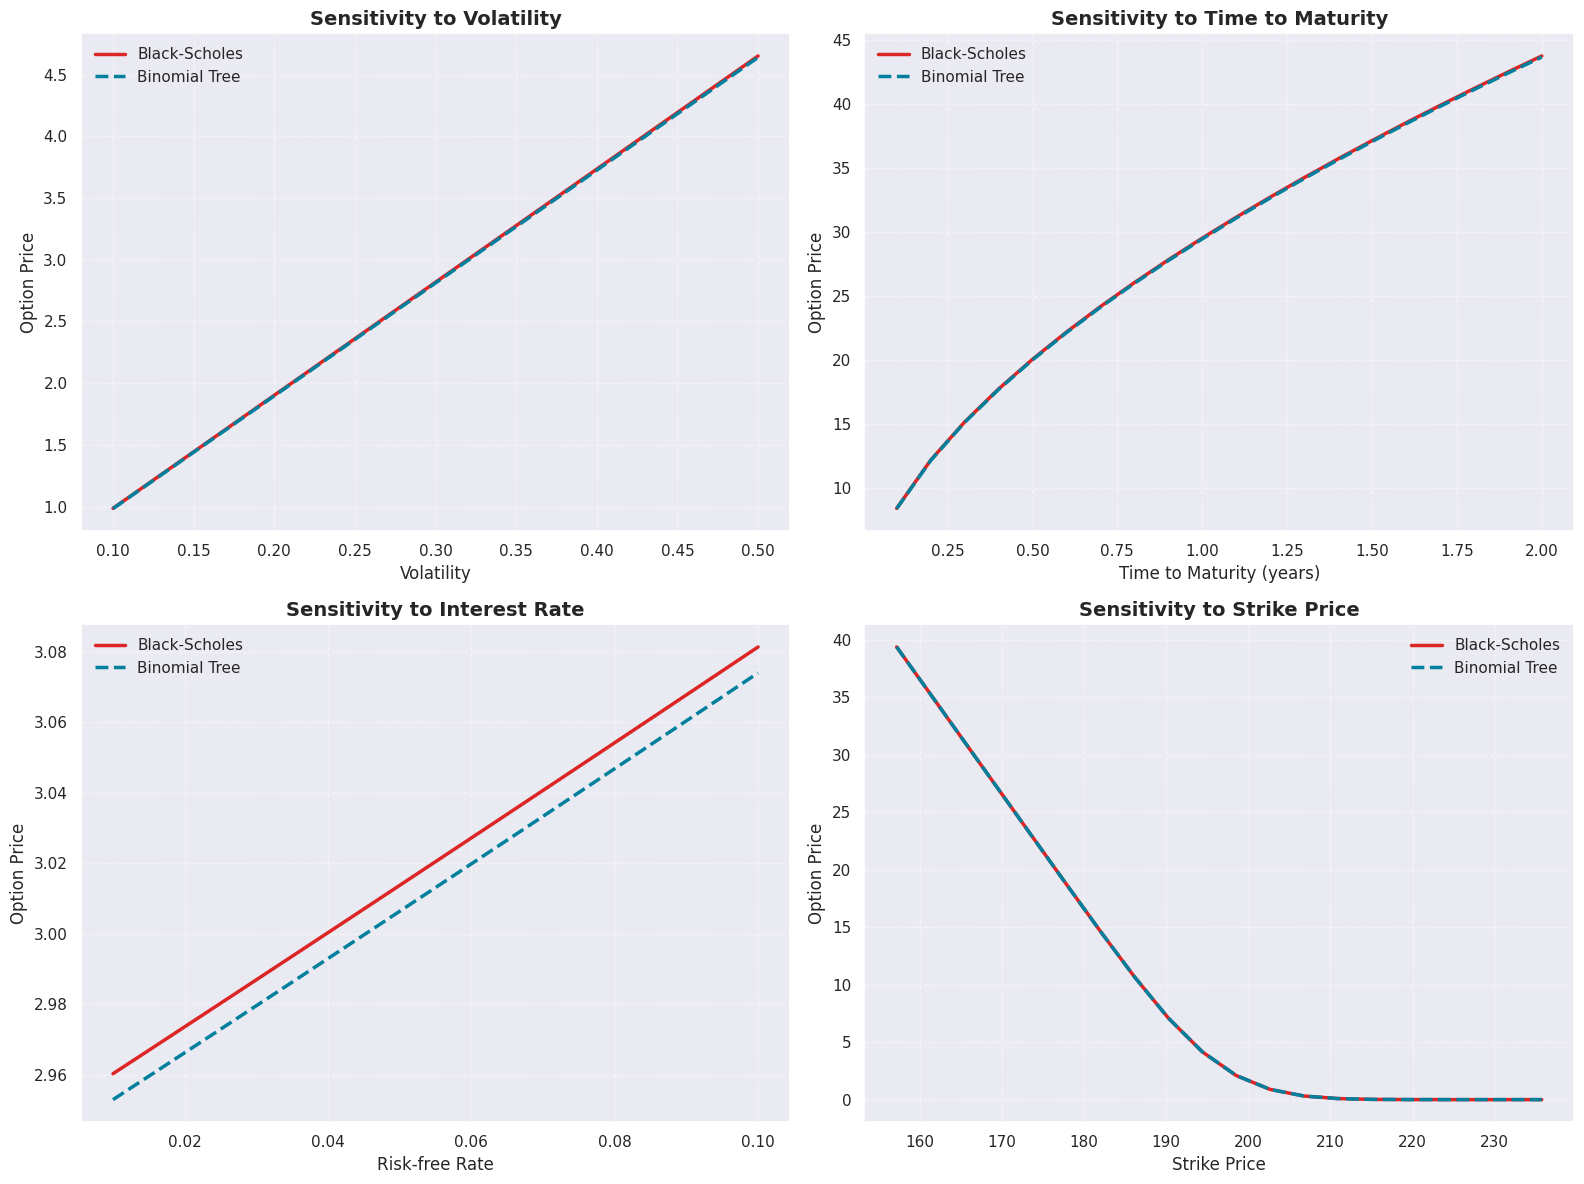

In [83]:
ticker = 'AAPL'
stock = get_stock(ticker)
S0 = get_current_price(ticker)
sigma = get_historical_volatility(ticker)
r = get_risk_free_rate()
expiry, T = get_valid_future_expiry(ticker)

base_params = {
    'S0': S0,
    'K': S0,
    'T': T,
    'r': r,
    'sigma': sigma
}

results = create_sensitivity_report(base_params, n_steps=100)
plot_sensitivity(results)


## **Pricing Accuracy of the models and Deviation from market prices**

In [84]:
def compare_models_on_strike_range(ticker='AAPL', option_type='call', steps_bt=100):
    stock = get_stock(ticker)

    expiry, T = get_valid_future_expiry(ticker)
    if not expiry:
        raise ValueError("No valid future expiry dates found.")

    S0 = get_current_price(ticker)
    sigma = get_historical_volatility(ticker)
    r = get_risk_free_rate()

    opt_chain = stock.option_chain(expiry)
    options_df = opt_chain.calls if option_type == 'call' else opt_chain.puts

    # Filter strikes to ±20% around S0
    options_df = options_df[(options_df['strike'] >= 0.8 * S0) & (options_df['strike'] <= 1.2 * S0)]

    rows = []
    for _, row in options_df.iterrows():
        K = row['strike']
        market_price = row['lastPrice']
        bid = row['bid']
        ask = row['ask']

        if market_price == 0 or np.isnan(market_price):
            continue

        bs = Black_Scholes_with_Greeks(S0, K, T, r, sigma, option_type)
        bt, _, _ = Binomial_Tree(S0, K, T, r, sigma, N=steps_bt, option_type=option_type)

        bs_price = bs['price']
        bt_price = bt

        # Errors against market price
        bs_error = abs(bs_price - market_price)
        bt_error = abs(bt_price - market_price)
        bs_pct_error = bs_error / market_price * 100
        bt_pct_error = bt_error / market_price * 100

        # Difference between BS and BT
        bs_bt_diff = bt_price - bs_price
        bs_bt_abs_diff = abs(bs_bt_diff)
        bs_bt_pct_diff = bs_bt_abs_diff / (bs_price + 1e-8) * 100  # Prevent divide-by-zero


        rows.append({
            'Strike': K,
            'Moneyness': round(S0 / K, 4),
            'Market Price': round(market_price, 4),
            'BS Price': round(bs_price, 6),
            'BT Price': round(bt_price, 6),
            'BS Abs Error': round(bs_error, 6),
            'BT Abs Error': round(bt_error, 6),
            'BS % Error': round(bs_pct_error, 4),
            'BT % Error': round(bt_pct_error, 4),
            'BT - BS Diff': round(bs_bt_diff, 6),
            'ATM Distance': abs(K - S0),
        })

    df = pd.DataFrame(rows)
    return df.sort_values(by='ATM Distance').drop(columns='ATM Distance').reset_index(drop=True)


In [85]:
df_results = compare_models_on_strike_range('AAPL', option_type='call')

if df_results is not None:
    display(df_results.head(10))


,Strike,Moneyness,Market Price,BS Price,BT Price,BS Abs Error,BT Abs Error,BS % Error,BT % Error,BT - BS Diff
0,197.5,0.9947,2.46,2.518941,2.523694,0.058941,0.063694,2.3960,2.5892,0.004753
1,195.0,1.0074,3.85,3.794545,3.788160,0.055455,0.061840,1.4404,1.6062,-0.006384
2,200.0,0.9822,1.40,1.572471,1.577777,0.172471,0.177777,12.3193,12.6984,0.005307
3,192.5,1.0205,5.50,5.400324,5.404144,0.099676,0.095856,1.8123,1.7428,0.003820
4,202.5,0.9701,0.74,0.919761,0.914366,0.179761,0.174366,24.2920,23.5629,-0.005396
5,190.0,1.0339,7.30,7.301440,7.304826,0.001440,0.004826,0.0197,0.0661,0.003386
6,205.0,0.9583,0.38,0.502737,0.504297,0.122737,0.124297,32.2993,32.7098,0.001560
7,187.5,1.0477,9.43,9.437089,9.436167,0.007089,0.006167,0.0752,0.0654,-0.000921
8,207.5,0.9467,0.20,0.256337,0.255813,0.056337,0.055813,28.1684,27.9064,-0.000524
9,185.0,1.0619,11.70,11.737342,11.734041,0.037342,0.034041,0.3192,0.2909,-0.003301


In [86]:
def compare_models_on_strike_range1(ticker='AAPL', option_type='call', steps_bt=1):
    stock = get_stock(ticker)

    expiry, T = get_valid_future_expiry(ticker)
    if not expiry:
        raise ValueError("No valid future expiry dates found.")

    S0 = get_current_price(ticker)
    sigma = get_historical_volatility(ticker)
    r = get_risk_free_rate()
    opt_chain = stock.option_chain(expiry)
    options_df = opt_chain.calls if option_type == 'call' else opt_chain.puts

    rows = []
    for _, row in options_df.iterrows():
        K = row['strike']
        market_price = row['lastPrice']
        bid = row['bid']
        ask = row['ask']

        if market_price == 0 or np.isnan(market_price):
            continue

        bs = Black_Scholes_with_Greeks(S0, K, T, r, sigma, option_type)
        bt, _, _ = Binomial_Tree(S0, K, T, r, sigma, N=steps_bt, option_type=option_type)

        bs_price = bs['price']
        bt_price = bt

        bs_error = abs(bs_price - market_price)
        bt_error = abs(bt_price - market_price)
        bs_pct_error = bs_error / market_price * 100
        bt_pct_error = bt_error / market_price * 100
        bs_bt_diff = bt_price - bs_price
        bs_bt_abs_diff = abs(bs_bt_diff)
        bs_bt_pct_diff = bs_bt_abs_diff / (bs_price + 1e-8) * 100

        rows.append({
            'Strike': K,
            'Moneyness': round(K / S0, 4),
            'Market Price': round(market_price, 4),
            'Bid': round(bid, 4),
            'Ask': round(ask, 4),
            'BS Price': round(bs_price, 6),
            'BT Price': round(bt_price, 6),
            'BS Abs Error': round(bs_error, 6),
            'BT Abs Error': round(bt_error, 6),
            'BS % Error': round(bs_pct_error, 4),
            'BT % Error': round(bt_pct_error, 4),
            'BT - BS Diff': round(bs_bt_diff, 6),
            '% Difference from BS': round(bs_bt_pct_diff, 6),
        })

    return pd.DataFrame(rows).sort_values(by='Strike').reset_index(drop=True)


def plot_model_vs_market_by_strike_side_by_side(df1, df2,
                                                 strike_range=None,
                                                 title1="BT steps = 1",
                                                 title2="BT steps = 100"):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    def plot(ax, df, title):
        if strike_range:
            df = df[(df['Strike'] >= strike_range[0]) & (df['Strike'] <= strike_range[1])]

        ax.plot(df['Strike'], df['Market Price'], 'o-', label='Market Price', color='black', markersize=10)
        ax.plot(df['Strike'], df['BS Price'], 's--', label='Black-Scholes', color='blue', markersize=8)
        ax.plot(df['Strike'], df['BT Price'], 'd--', label='Binomial Tree', color='red', markersize=8)

        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('Strike Price (K)')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend()

    plot(axs[0], df1, title1)
    plot(axs[1], df2, title2)

    axs[0].set_ylabel('Option Price ($)')
    plt.tight_layout(w_pad=4)
    plt.show()


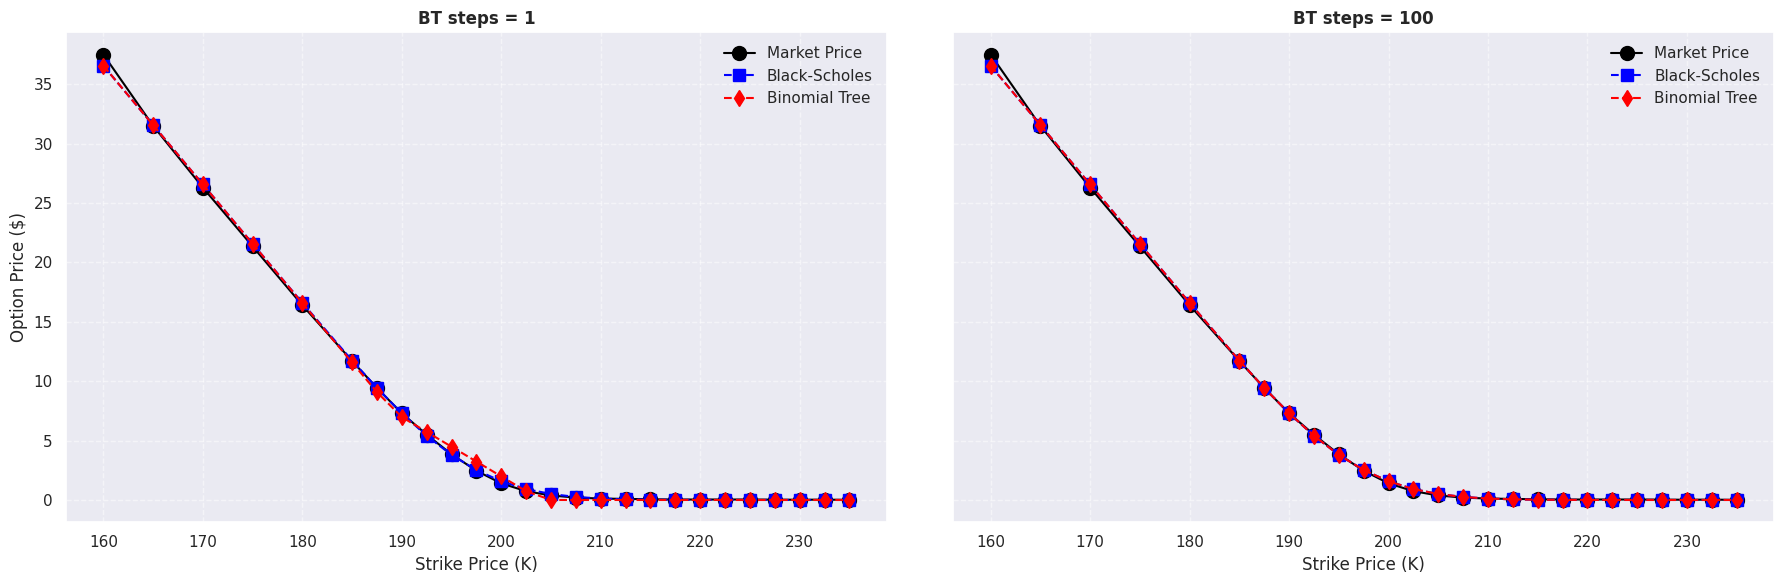

In [87]:
df1 = compare_models_on_strike_range1('AAPL', option_type='call')
df2 = compare_models_on_strike_range1('AAPL', option_type='call', steps_bt=100)
S0 = get_current_price('AAPL')
x = 0.8 * S0
y = 1.2 * S0
plot_model_vs_market_by_strike_side_by_side(df1, df2, strike_range=(x, y))


In [88]:
def plot_deviation_vs_strike_side_by_side(df_results1, df_results2,
                                           strike_range=None,
                                           title1="BT steps = 1",
                                           title2="BT steps = 100"):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    def plot(ax, df_results, title):
        # Filter by strike range
        if strike_range:
            df = df_results[(df_results['Strike'] >= strike_range[0]) & (df_results['Strike'] <= strike_range[1])]
        else:
            df = df_results

        ax.plot(df['Strike'], df['BS Price'] - df['Market Price'],
                's--', label='BS Deviation', color='black', markersize=8)
        ax.plot(df['Strike'], df['BT Price'] - df['Market Price'],
                'd--', label='BT Deviation', color='red', markersize=8)

        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('Strike Price (K)')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend()

    # Plot both sides
    plot(axs[0], df_results1, title1)
    plot(axs[1], df_results2, title2)

    axs[0].set_ylabel('Signed Deviation (Model − Market)')
    plt.tight_layout(w_pad=4)  # space between the two plots
    plt.show()

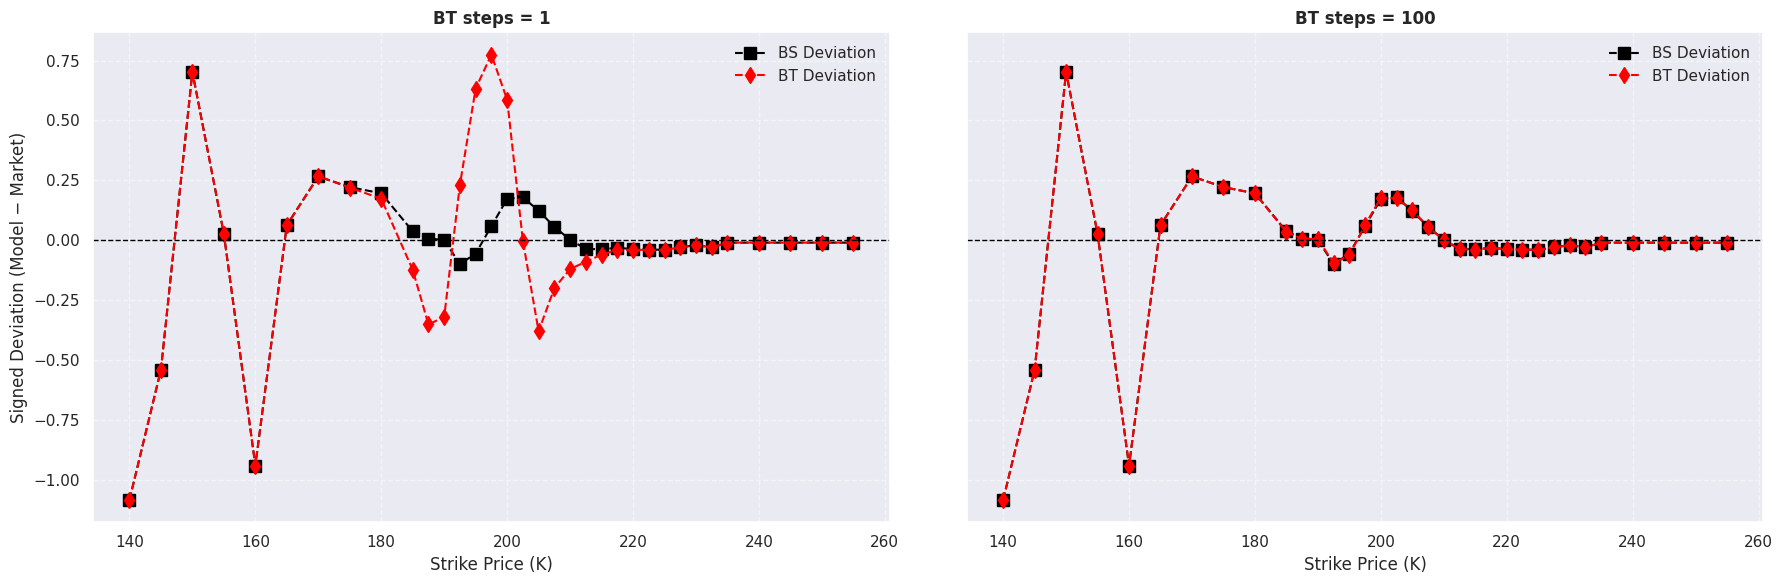

In [89]:
df1 = compare_models_on_strike_range1('AAPL', option_type='call')
df2 = compare_models_on_strike_range1('AAPL', option_type='call', steps_bt=100)

S0 = get_current_price('AAPL')
x = 0.7 * S0
y = 1.3 * S0
plot_deviation_vs_strike_side_by_side(df1, df2, strike_range=(x, y))


## **Error Convergence of Binomial tree model**

In [90]:
def binomial_error_analysis(S0, K, T, r, sigma, option_type='call', steps_range=None):
    """
    Analyze how the Binomial Tree model converges to Black-Scholes as steps increase.
    Returns a DataFrame with BT prices, errors, and accuracy.
    """
    if steps_range is None:
        steps_range = [5, 10, 20, 50, 100, 200, 500, 1000]

    bs_result = Black_Scholes_with_Greeks(S0, K, T, r, sigma, option_type)
    bs_price = bs_result['price']

    bt_prices = []
    errors = []
    for N in steps_range:
        bt_price, _, _ = Binomial_Tree(S0, K, T, r, sigma, N=N, option_type=option_type)
        error = abs(bt_price - bs_price)
        bt_prices.append(bt_price)
        errors.append(error)

    df = pd.DataFrame({
        'Steps': steps_range,
        'BT Price': bt_prices,
        'BS Price': [bs_price] * len(steps_range),
        'Absolute Error': errors,
        'Percentage Error': [round(100 * e / bs_price, 4) for e in errors],
        'Accuracy (%)': [round(100 - 100 * e / bs_price, 4) for e in errors]
    })

    return df

In [91]:
def plot_error_convergence(df):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Left Y-axis for Error
    color = 'tab:red'
    ax1.set_xlabel('Number of Steps (N)')
    ax1.set_ylabel('Percentage Error (%)', color=color)
    ax1.plot(df['Steps'], df['Percentage Error'], 'o-', color=color, label='Percentage Error (%)')
    ax1.tick_params(axis='y', labelcolor=color)

    # Right Y-axis for Accuracy
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:green'
    ax2.set_ylabel('Accuracy (%)', color=color)
    ax2.plot(df['Steps'], [100 - e for e in df['Percentage Error']], 's--', color=color, label='Accuracy (%)')
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and layout
    plt.title('Binomial Tree Error Convergence')
    fig.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.3)

    # Legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

    plt.show()

Convergence Analysis:
   Steps  BT Price  BS Price  Absolute Error  Percentage Error  Accuracy (%)
0      5  3.163632  3.013691        0.149940            4.9753       95.0247
1     10  2.941062  3.013691        0.072629            2.4100       97.5900
2     20  2.977105  3.013691        0.036586            1.2140       98.7860
3     50  2.998997  3.013691        0.014694            0.4876       99.5124
4    100  3.006335  3.013691        0.007357            0.2441       99.7559
5    200  3.010011  3.013691        0.003681            0.1221       99.8779
6    500  3.012219  3.013691        0.001473            0.0489       99.9511
7   1000  3.012955  3.013691        0.000737            0.0244       99.9756


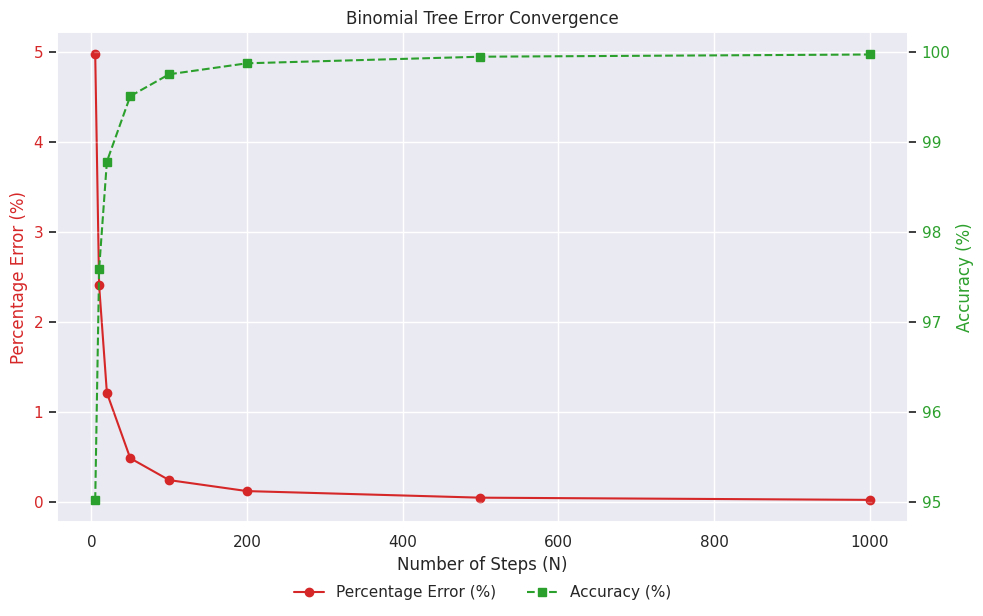

In [92]:
ticker = 'AAPL'
S0 = get_current_price(ticker)
sigma = get_historical_volatility(ticker)
r = get_risk_free_rate()
K = S0
expiry, T = get_valid_future_expiry(ticker)

convergence_df = binomial_error_analysis(S0, K, T, r, sigma, option_type='call')

print("Convergence Analysis:")
print(convergence_df)

plot_error_convergence(convergence_df)

## **Visulaization of Binomial tree model upto 5 steps**

In [93]:
def visualize_binomial_tree(stock_tree, option_tree, n_steps=5):
    if n_steps > 5:
        print("Tree visualization only shown for n_steps <= 5")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

    for i in range(n_steps + 1):
        for j in range(i + 1):
            ax1.text(i, j - i/2, f'${stock_tree[j, i]:.2f}',
                    ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='#4DA8DA'))

            if i < n_steps:
                ax1.plot([i, i+1], [j - i/2, j - (i+1)/2], 'k-', alpha=0.3)
                ax1.plot([i, i+1], [j - i/2, j+1 - (i+1)/2], 'k-', alpha=0.3)

    ax1.set_title('Stock Price Tree')
    ax1.set_xlabel('Time Step')
    ax1.axis('off')

    for i in range(n_steps + 1):
        for j in range(i + 1):
            ax2.text(i, j - i/2, f'${option_tree[j, i]:.2f}',
                    ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='#FFB823'))

            if i < n_steps:
                ax2.plot([i, i+1], [j - i/2, j - (i+1)/2], 'k-', alpha=0.3)
                ax2.plot([i, i+1], [j - i/2, j+1 - (i+1)/2], 'k-', alpha=0.3)

    ax2.set_title('Option Value Tree')
    ax2.set_xlabel('Time Step')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

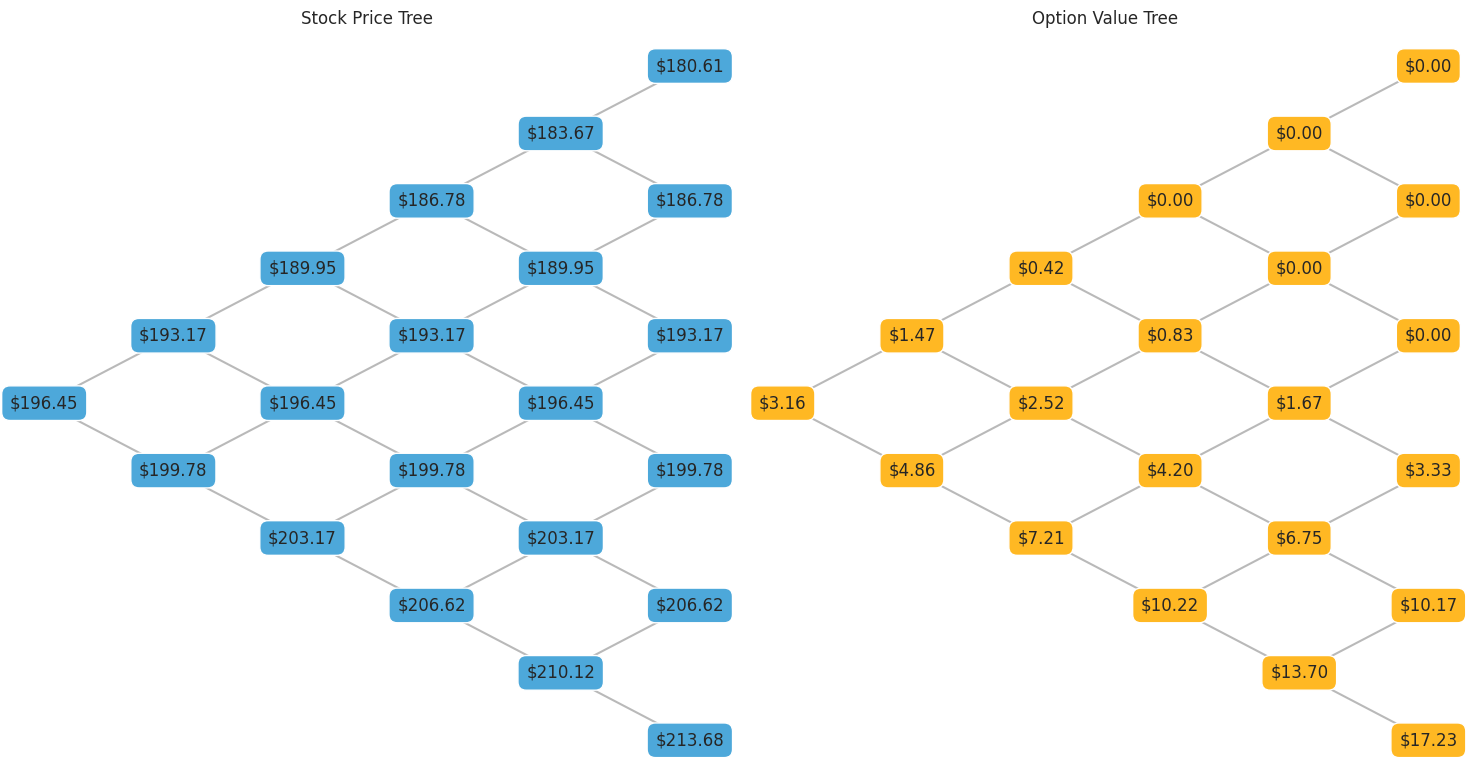

In [94]:
ticker = 'AAPL'
S0 = get_current_price(ticker)
sigma = get_historical_volatility(ticker)
r = get_risk_free_rate()
K = S0
expiry, T = get_valid_future_expiry(ticker)

bs_result = Black_Scholes_with_Greeks(S0, K, T, r, sigma, 'call')
bs_price = bs_result['price']

bt_price, _, _ = Binomial_Tree(S0, K, T, r, sigma, N=100, option_type='call')

small_bt_price, stock_tree, option_tree = Binomial_Tree(S0, K, T, r, sigma, N=5, option_type='call')

visualize_binomial_tree(stock_tree, option_tree, n_steps=5)

## **Performance analysis report**

## 1. Mathematical Assumptions

#### **Black-Scholes Model Assumptions**
- **Continuous Time**:
  - Continuous-time model based on **stochastic calculus**.
  - Uses geometric Brownian motion to describe asset price evolution.
  - No discrete jumps — changes are infinitesimally small and constant over time.
- **Constant Volatility**: Volatility does not change over time, which makes it easier to find the option price but that is not true for real life data.
- **Constant Risk-Free Rate**: The interest rate used for discounting is fixed.
- **No Arbitrage**: No riskless profit opportunities exist.
- **Frictionless Market**: No transaction costs or taxes, and assets are infinitely divisible.
- **No Dividends**: Basic model assumes the underlying doesn't pay dividends (can be extended).
- **European Options Only**: Can only be exercised at expiration.
- **Lognormal Distribution**: Asset returns are normally distributed (prices are lognormally distributed).

> These assumptions allow us to find the closed form solution of option prices using partial differential equations.


#### **Binomial Tree Model Assumptions**
- **Discrete Time**:
  - Discrete-time model: time is divided into a finite number of intervals (N steps).
  - Each time step allows the asset price to move **up** or **down**.
  - The model **converges to continuous time** processes as N -> ∞.
- **Stepwise Constant Volatility**: Volatility is constant within each step but can be adapted more easily.
- **Risk-Neutral Valuation**: Uses risk-neutral probabilities derived from no-arbitrage arguments.
- **No Arbitrage**: Like Black-Scholes, arbitrage opportunities are not allowed.
- **Can Handle Dividends**: Easier to incorporate dividend payments.
- **American and European Options**: Can model both, making it more flexible in practice.
- **Numerical Solution**: No closed-form solution; uses backward induction.

> As the number of steps increases, the Binomial Tree model converges to the Black-Scholes price for European options.


#### **Summary Table**

| Assumption              | Black-Scholes                 | Binomial Tree                        |
|-------------------------|-------------------------------|--------------------------------------|
| Time                    | Continuous                    | Discrete                             |
| Volatility              | Constant                      | Stepwise constant                    |
| Risk-Free Rate          | Constant                      | Constant                             |
| Option Type             | European only                 | European & American                  |
| Dividends               | Not supported (basic model)   | Easily incorporated                  |
| Solution Type           | Analytical (closed-form)      | Numerical (tree-based)               |
| Flexibility             | Low (fixed assumptions)       | High (more adaptable)                |

---

## 2. Convergence Analysis

We will analyze the accuracy of the Binomial Tree model and see  how its option price prediction converges to the Black-Scholes price as the number of time steps (`N`) increases.

> we are analyzing the plots made in the section **Binomial Tree Convergence and Computational Effeciency**

### Empirical Observation from the real life market data(AAPL):

- **Black-Scholes benchmark price**: $3.01
- **Convergence pattern**: As the number of steps increases, the Binomial Tree price approaches the Black-Scholes price smoothly and rapidly.

| Steps (N) | Binomial Price | Absolute Error | Percentage Error |
|-----------|----------------|----------------|------------------|
| 10        | \$2.9411        | \$0.0689        | 2.41%            |
| 20        | \$2.9771        | \$0.0329        | 1.21%            |
| 50        | \$2.9990        | \$0.0110        | 0.49%            |
| 100       | \$3.0063        | \$0.0037        | 0.24%            |
| 200       | \$3.0100        | \$0.0000        | 0.12%            |

we can clearly observe from the convergence graph that:
- For **low step counts** (e.g., 10–20), the Binomial model underestimates the option value.
- As **N increases**, the error rapidly diminishes.
- By **100+ steps**, the Binomial Tree model provides very close approximations (within 0.1%) to the Black-Scholes value.

This confirms the **theoretical expectation** that the Binomial Tree model converges to the Black-Scholes price when the number of steps tends to infinity. For practical applications:
- **≥100 steps** are enough for pricing the european options to get a **< 1% error**

---

## 3. Computational Effeciency Analysis

We will analyze the computational effeciency of the Binomial Tree model and the black-scholes model.
We will also see how does the number of steps (N) in binomial tree model effect its computaional effeciency.

> we are analyzing the plots made in the section **Binomial Tree Convergence and Computational Effeciency**

**Black-Scholes Model:**
- It uses mathematical functions like logarithm, square root, and cumulative normal distribution to get the closed form formula.
- **Time Complexity:** O(1)
- **Space Complexity:** O(1)

- Extremely fast and suitable for real-time pricing.

**Binomial Tree Model:**
- Constructs a recombining price tree of ( N ) steps and performs backward induction to compute option value.
- **Time Complexity:** O(N^2)
- **Space Complexity:** O(N^2) (standard implementation to get the tree as well)
> You can reduce space to 𝑂(N) by storing only the current and next rows.

- Quite slower, especiialy for large value of steps ( N).

### Empirical Observation from the real life market data(AAPL):

- from the graph we can observe that as the number of steps (N) increases in the Binomial Tree Model, the computation time grows approximately as a quadratic function of N — i.e., O(N^2).
- This is evident from the shape of the computation time graph, which follows an approximately parabolic curve.

---

## 4. Sensitivity Analysis of Option Prices

We analyze how option prices computed by the **Black-Scholes model** and the **Binomial Tree model** vary with changes in key parameters.

> we are analyzing the plots made in the section **Sensitivity of model prices to various factors**

#### 1. Sensitivity to Volatility (σ)

- **Observation**: As volatility increases, the option price increases for both models.
- **Reason**: Higher volatility increases the potential for the option to end up in-the-money region (explained in **pricing accuracy analysis**).
- **Model Agreement**: Both the models follow exact same trend which is as theoretically expected. The Binomial Tree matches the analytical Black-Scholes solution as expected when the number of steps is sufficiently high (N > 100).


#### 2. Sensitivity to Time to Maturity (T)

- **Observation**: Option price increases with longer time to maturity.
- **Reason**: More time allows for greater price movement and increases the expected payoff.
- **Model Agreement**: Again, the two models follows same trend.

#### 3. Sensitivity to Interest Rate (r)

- **Observation**: As the risk-free rate increases, the option price also increases (for call options).
- **Reason**: A higher discount factor reduces the present value of the strike, making call options more valuable.
- **Model Behavior**: The Black-Scholes model prices are slightly higher than the Binomial Tree prices for the same rate. This small deviation is expected due to discretization error in the tree model, especially with a lower number of steps.


#### 4. Sensitivity to Strike Price (K)

- **Observation**: Option price decreases as strike price increases.
- **Reason**: A higher strike price means a lower chance for a profitable (in-the-money) call option.
- **Model Agreement**: Both models show almost identical behavior across the full range.

---

## 5. Pricing Accuracy and Deviation from Market Prices

We now analyze the pricing accuracy of the **Black-Scholes (BS)** and **Binomial Tree (BT)** models by comparing their outputs to market prices.

> we are analyzing the plots made in the section **Pricing Accuracy of the models and Deviation from market prices**

### Empirical Observation from the real life market data(AAPL):

- With **very few steps (e.g., BT steps = 1 - 5)**, the Binomial Tree performs poorly around the **at-the-money (ATM)** region, where strike price is **K ≈ S0** .
- The Black-Scholes model, while better, still shows some amount of deviation from the market price.
- When **BT steps are increased (e.g., to 100)**, we can see from the graph that prices estimated by binomial tree and black scholes overlap perfectly, as expected.
- The most noticeable deviations occur in the **ATM region**, where option pricing is most sensitive to inputs.

### Why Do Models Converge at ( K << S0 ) and ( K >> S0 )?

This behavior can be intuitively understood by examining the payoff profile of call options:

| Region | Option Moneyness | Model Deviation | Convergence Behavior |
|--------|------------------|------------------|----------------------|
| ( K << S0 ) | Deep In-the-Money | Low deviation |  Models converge |
| ( K ≈ S0 ) | At-the-Money | High deviation |  Models diverge |
| ( K >> S0 ) | Deep Out-of-the-Money | Low deviation |  Models converge |

- **Deep In-the-Money ( K << S0 ):**
  - The call option is **almost certainly exercised**.
  - Both BS and BT predict a value close to the **intrinsic value**, i.e., ( S0 - K e^{-rT} ).
  - Hence, both the models converge exactly
  - Usualy the boundary of **Deep In-the-Money** is **k <= S0 * 0.9**, i.e 10 % less than S0.

- **Deep Out-of-the-Money ( K >> S0 ):**
  - The call option will **almost certainly expire worthless**.
  - Both models assign a price close to **zero**.
  - so, again they will coincide.
  - Usualy the boundary of **Deep Out-of-the-Money** is **k >= S0 * 1.1**, i.e 10 % more than S0.

- **At-the-Money ( K ≈ S0 ):**
  - The outcome is **most uncertain**, and the pricing becomes highly sensitive to volatility and numerical precision.
  - With less number of steps in the BT model, inaccuracies in probability estimation are more observed.
  - Thus, **this is where models diverge the most**.

---

## 6. Error Convergence Analysis

We analyze how the error or deviation of Binomial Tree model converges to 0 as the number of steps increases.

> we are analyzing the table and plot made in the section **Error Convergence of Binomial tree model**

### Empirical Observation from the real life market data(AAPL):

| Steps | BT Price | BS Price | Absolute Error | % Error | Accuracy (%) |
|-------|----------|----------|----------------|---------|---------------|
| 5     | 3.1636   | 3.0137   | 0.1499         | 4.9753  | 95.02%        |
| 10    | 2.9411   | 3.0137   | 0.0726         | 2.4100  | 97.59%        |
| 20    | 2.9771   | 3.0137   | 0.0366         | 1.2140  | 98.79%        |
| 50    | 2.9990   | 3.0137   | 0.0147         | 0.4876  | 99.51%        |
| 100   | 3.0064   | 3.0137   | 0.0074         | 0.2441  | 99.76%        |
| 200   | 3.0100   | 3.0137   | 0.0037         | 0.1221  | 99.88%        |
| 500   | 3.0122   | 3.0137   | 0.0015         | 0.0489  | 99.95%        |
| 1000  | 3.0130   | 3.0137   | 0.0007         | 0.0244  | 99.98%        |

We can observe from the graph:
- **Red Line**: Represents the **percentage error** in the Binomial Tree price.
- **Green Line**: Represents the **accuracy** (%) compared to the Black-Scholes price.
- Both curves show a steep improvement initially, with diminishing error as steps increase.
- Beyond ~200 steps, the accuracy plateaus above **99.9%**.

---

## 7. Model Preference: When to Use Which Model?

Based on our analysis, both the **Black-Scholes** and **Binomial Tree** models are capable of pricing European options accurately. However, each model has its own strengths that makes it preferable under different conditions:

### Black-Scholes Model:
- **Speed is essential**: The closed-form solution allows for rapid computation.
- **European-style options**: The model assumes no early exercise, aligning with European contracts.
- **Market conditions match assumptions**: Works best when volatility is **constant**, markets are **efficient**, and prices follow a **log-normal distribution** in continuous time.
- **Quick scenario testing**: Ideal for sensitivity analysis due to fast computation and direct Greeks derivation.

### Binomial Tree Model:
- **Understanding dynamics is important**: It provides an intuitive, step-by-step evolution of stock and option values.
- **Educational or demonstrative purposes**: The tree structure helps visualize option valuation over time.
- **Approximate flexibility needed**: Though not as suited as trinomial or finite-difference models, binomial trees can adapt better to:
  - Discrete dividend payments
  - Custom payoff structures (though less relevant for plain European options)
- **Convergence to BS**: When using a high number of steps, it converges closely to Black-Scholes price, validating its accuracy.

## **Conclusion**

In this analysis, we explored and compared two classic models for pricing European-style options — the **Black-Scholes model** and the **Binomial Tree model**.

Each model has its own strengths, and working with both gave us a clearer understanding of how option pricing works in theory and how well these models match real market behavior.

- **Black-Scholes** is fast and efficient thanks to its closed-form formula. It works really well for standard European options, assuming the market fits its assumptions (like constant volatility and log-normal price movement).

- **Binomial Tree**, while slower for large step sizes, is very flexible and intuitive. It shows good convergence to the Black-Scholes price as we increase the number of steps — usually around 100 steps is enough for great accuracy.



Overall, the **Binomial Tree model** serves as a versatile tool for understanding option dynamics and handling non-standard features, while **Black-Scholes** remains the industry-standard benchmark for quick and accurate pricing of European options.

---

## **References**


1. *Options, Futures, and Other Derivatives* – John C. Hull (9th Edition), Pearson.
2. Python libraries used:
  - `yfinance` – for collecting real historical options and stock data.
  - `NumPy`, `Pandas` – for data analysis and calculations
  - `Matplotlib` – for plotting and visualizations
  -  `Seaborn` – for enhanced and styled plots
  - `datetime` – for handling expiry dates and timestamps
  - `time` – used for timing code execution  